In [70]:
import PIL
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import time
import random
import json
import csv
import pathlib
from os import listdir
from os.path import isfile, join

In [2]:
#image1 = Image.new(mode='L', size = (64,64), color=255)


#draw = ImageDraw.Draw(image1)
#font = ImageFont.truetype("meiryo.ttc", 50)
#font = ImageFont.truetype("yumin.ttf", 50)
#font = ImageFont.truetype("YuGothM.ttc", 50)
#font = ImageFont.truetype("msmincho.ttc", 50)

#draw.text((0, 0), ,(0))
#draw.text((5, 5),u"魔",(0), font=font)
#image1.show()

In [4]:
def createImage(pixelSize=64,symbol=u"魔",key=-1):
    image1 = Image.new(mode='L', size = (pixelSize,pixelSize), color=255)
    draw = ImageDraw.Draw(image1)
    
    
    fontSize = math.ceil(pixelSize*0.78)
    fontOffsetX = math.floor(pixelSize*0.22/2)
    fontOffsetY = math.floor(pixelSize*0.22/4)
    fonts = [
        ImageFont.truetype("meiryo.ttc", fontSize), #Requires japanese language to be added as a language in windows options
        ImageFont.truetype("yumin.ttf", fontSize),
        ImageFont.truetype("YuGothM.ttc", fontSize),
        ImageFont.truetype("msmincho.ttc", fontSize)
    ]
    
    draw.rectangle((0,0,pixelSize,pixelSize), 255)
    for font in fonts:
        t = draw.text((fontOffsetX, fontOffsetY),symbol,(0), font=font)
        filename = u"./Training_set/"+str(key) +"_"+ symbol +"_"+ font.getname()[0] +"_"+ font.getname()[1]
        
        image1.save(filename+".jpg")
        
        draw.rectangle((0,0,pixelSize,pixelSize), 255)
        
    
    
    
    
#createImage(pixelSize=40,symbole=u"魔",key=0)

def sortValue(item):
    return item[1]

num2jap_dict = {}
jap2num_dict = {}
with open('memrise_rtk_kanji.csv', encoding='utf-8', mode='r') as infile:
    reader = csv.reader(infile)
    
    jap2num_dict = {rows[0]:int(rows[1]) for rows in reader}
    jap_list = list(jap2num_dict.items())
    jap_list.sort(key=sortValue)
    
    for index in range(len(jap_list)):
        symbol = jap_list[index][0]
        key = index+1
        createImage(pixelSize=40,symbol=symbol,key=key)
        #print(symbol + " " + str(key))
   
        
mypath = pathlib.Path().resolve()
picturesNames = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [10]:
def sortValue(item):
    return item[1]

with open('memrise_rtk_kanji.csv', encoding='utf-8', mode='r') as infile:
    reader = csv.reader(infile)
    jap2num_dict = {rows[0]:int(rows[1]) for rows in reader}
    num2jap_dict = {int(rows[1]):rows[0] for rows in reader}
    jap_list = list(jap2num_dict.items())
    jap_list.sort(key=sortValue)
    
    for index in range(len(jap_list)):
        symbol = jap_list[index][0]
        num2jap_dict[index]=symbol
    
    string_dict = json.dumps(num2jap_dict)
    with open('num2kanji_dict.json', 'w') as outfile:
        outfile.write(string_dict)

In [67]:
def testCreateImageRotations(pixelSize=64,symbol=u"魔",font=None,key=-1,foreground=(0,0,0,255),background=(255,255,255,255),angle=0):
    fontSize = math.ceil(pixelSize*0.78)
    fontOffsetX = math.floor(pixelSize*0.22/2)
    fontOffsetY = math.floor(pixelSize*0.22/4)
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", fontSize)
    
    image1 = Image.new(mode='RGBA', size = (pixelSize,pixelSize), color=(255,255,255,0))
    background1 = Image.new(mode='RGBA', size = (pixelSize,pixelSize), color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
    sampling = PIL.Image.Resampling.BICUBIC
    
    image_rot = background1.rotate(0,sampling)
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling))
    
    image_rot.show()


In [52]:
testCreateImageRotations(pixelSize=64,symbol=u"魔",key=-1,foreground=(30,30,30,255),background=(235,235,235,255),angle=90)

In [65]:
num2kanji_dict = {}
with open('num2kanji_dict.json', 'r') as f:
  num2kanji_dict = json.load(f)

def createImageRotations(pixelSize=64,symbol=u"魔",font=None, yBaseOffset=0,key=-1,foreground=(0,0,0,255),background=(255,255,255),angle=0,seed=0) -> Image:
    random.seed(seed)
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", 40)
    
    fontSize = font.size
    
    #randXOffset = random.randrange((font.size//4) + 1) - font.size//8
    #randYOffset = random.randrange((font.size//4) + 1) - font.size//8
    
    randXOffset = random.randrange(17)-8
    randYOffset = random.randrange(17)-8
    
    fontOffsetX = (pixelSize-fontSize)//2 + randXOffset
    fontOffsetY = yBaseOffset*fontSize +(pixelSize-fontSize)//2 + randYOffset
    
    perturbationOffset = fontSize
    
    
    
    image1 = Image.new(mode='RGBA', size = (pixelSize,pixelSize), color=(255,255,255,0))
    background1 = Image.new(mode='RGB', size = (pixelSize,pixelSize), color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
    sampling = PIL.Image.Resampling.BICUBIC
    
    image_rot = background1.copy()
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling).split()[3])
    
    #Add perturbations
    
    if random.randrange(2) == 0:
        #print("Success")
        
        decider = random.randrange(4)
        x = -1 if decider==0 else (1 if decider==1 else 0)
        y = -1 if decider==2 else (1+(yBaseOffset*0.5) if decider==3 else 0)
        
        n_kanji = random.randrange(len(num2kanji_dict))
        kanjiPerturbation = num2kanji_dict[str(n_kanji)]
        
        image2 = Image.new(mode='RGBA', size = (pixelSize,pixelSize), color=(255,255,255,0))
        draw2 = ImageDraw.Draw(image2)
        draw2.text((fontOffsetX + x*perturbationOffset , fontOffsetY + y*perturbationOffset), kanjiPerturbation, foreground, font=font)
        image_rot.paste(image2.rotate(angle,sampling), (0, 0), image2.rotate(angle,sampling).split()[3])
        
    #image_rot.show()
    return image_rot

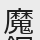

In [67]:
tempFont = ImageFont.truetype("meiryo.ttc", 30)
createImageRotations(
    pixelSize=40,
    symbol=u"魔",
    font=tempFont,
    yBaseOffset=-0.15,
    key=-1,foreground=(30,30,30,255),
    background=(235,235,235,255),
    angle=0,
    seed=4 #4 has a symbol lower down
)

In [73]:
color_settings = [
    {'foreground':(0,0,0,255), 'background':(255,255,255)},
    {'foreground':(255,255,255,255), 'background':(0,0,0)},
    {'foreground':(90,90,90,255), 'background':(235,235,235)},
    {'foreground':(235,235,235,255), 'background':(90,90,90)}
]

rotations = [10,0,-10]

fontSizes = [25,35,50]

def createImage2(pixelSize=64,symbol=u"魔",key=-1):
    #fontSize = math.ceil(pixelSize*0.78)
    #fontOffsetX = math.floor(pixelSize*0.22/2)
    #fontOffsetY = math.floor(pixelSize*0.22/4)
    
    
    
    num_iter = 0
    for size in fontSizes:
        
        fonts = [
            {'font_value':ImageFont.truetype("meiryo.ttc", size), 'offset':-0.15}, #Requires japanese language to be added as a language in windows options
            {'font_value':ImageFont.truetype("yumin.ttf", size), 'offset':0},
            {'font_value':ImageFont.truetype("YuGothB.ttc", size), 'offset':0},
            {'font_value':ImageFont.truetype("./Fonts/DelaGothicOne-Regular.ttf", size), 'offset':-0.25}
            #ImageFont.truetype("YuGothM.ttc", fontSize),
            #ImageFont.truetype("msmincho.ttc", fontSize)
        ]
        
        for font_obj in fonts:
            for color_setting in color_settings:
                for rotation in rotations:

                    num_iter += 1

                    fore = color_setting['foreground']
                    back = color_setting['background']
                    
                    font = font_obj['font_value']
                    fontYOffset = font_obj['offset']
                    
                    image1 = createImageRotations(
                        pixelSize=pixelSize,
                        symbol=symbol,
                        font=font,
                        yBaseOffset=fontYOffset,
                        key=key,
                        foreground=fore,
                        background=color_setting['background'],
                        angle=rotation,
                        seed=key*num_iter
                    )

                    #filename = u"./Training_set/"+str(key) +"_"+ symbol +"_"+ font.getname()[0] +"_"+ font.getname()[1]  +"_fore("+ str(fore[0]) + ")_back("+ str(back[0]) + ")_rot(" + str(rotation) + ")"
                    filename = u"./Training_set/"+str(key) +"_"+ symbol +"_"+ str(num_iter) +"_"+ font.getname()[0] +"_"+ font.getname()[1]
                    image1.save(filename+".jpg")
    

In [74]:
def sortValue(item):
    return item[1]

num2jap_dict = {}
jap2num_dict = {}
with open('memrise_rtk_kanji.csv', encoding='utf-8', mode='r') as infile:
    reader = csv.reader(infile)
    
    jap2num_dict = {rows[0]:int(rows[1]) for rows in reader}
    jap_list = list(jap2num_dict.items())
    jap_list.sort(key=sortValue)
    
    start = time.time()
    for index in range(len(jap_list)):
        symbol = jap_list[index][0]
        key = index+1
        createImage2(pixelSize=40,symbol=symbol,key=key)
        if index%100==99:
            end = time.time()
            ratio = index/len(jap_list)
            dt = end-start
            expected_time = math.floor(dt*((1-ratio)/ratio))
            
            percent = 100*ratio
            percent = math.floor(100*percent)/100
            print(str(percent)+"% of pictures generated. Estimated time left : " 
                  + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
print("100% of pictures generated.)

4.5% of pictures generated. Estimated time left : 4m 50s
9.04% of pictures generated. Estimated time left : 4m 30s
13.59% of pictures generated. Estimated time left : 4m 15s
18.14% of pictures generated. Estimated time left : 4m 2s
22.69% of pictures generated. Estimated time left : 3m 49s
27.23% of pictures generated. Estimated time left : 3m 35s
31.78% of pictures generated. Estimated time left : 3m 21s
36.33% of pictures generated. Estimated time left : 3m 8s
40.88% of pictures generated. Estimated time left : 2m 55s
45.42% of pictures generated. Estimated time left : 2m 42s
49.97% of pictures generated. Estimated time left : 2m 28s
54.52% of pictures generated. Estimated time left : 2m 15s
59.07% of pictures generated. Estimated time left : 2m 2s
63.61% of pictures generated. Estimated time left : 1m 49s
68.16% of pictures generated. Estimated time left : 1m 36s
72.71% of pictures generated. Estimated time left : 1m 24s
77.26% of pictures generated. Estimated time left : 1m 10s
81.